In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [2]:

# Specify the path to the data file
file_path = '../data/cleaned_data.csv'

# Load the data into a DataFrame
df = pd.read_csv(file_path)



# session frequency for each user

In [3]:
# Calculate session frequency for each user
session_frequency =df['MSISDN/Number'].value_counts()
print("Session Frequency per User:")
print(session_frequency)


Session Frequency per User:
MSISDN/Number
3.373167e+10    22962
3.360304e+10      822
3.362632e+10       18
3.362578e+10       17
3.361489e+10       17
                ...  
3.366099e+10        1
3.366215e+10        1
3.366649e+10        1
3.362206e+10        1
3.361962e+10        1
Name: count, Length: 88753, dtype: int64


## Session Duration

In [24]:


# Assuming the data is in a pandas DataFrame named 'df'
session_duration = df.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Session Duration')
print(session_duration.sort_values('Session Duration', ascending=False))


       MSISDN/Number  Session Duration
88752   3.373167e+10      2.336299e+09
0       3.360304e+10      7.783054e+07
12428   3.362578e+10      4.137804e+06
12772   3.362632e+10      4.006827e+06
5744    3.361489e+10      3.899805e+06
36060   3.365973e+10      3.492198e+06
74954   3.367588e+10      3.331851e+06
63862   3.366716e+10      3.113767e+06
44      3.360313e+10      2.855128e+06
13236   3.362708e+10      2.782060e+06


# Calculate the total traffic per session


In [6]:
total_traffic_per_session = df['Total DL (Bytes)'] + df['Total UL (Bytes)']
print("\nTotal Traffic per Session:")
print(total_traffic_per_session)


Total Traffic per Session:
0         872988322.0
1         651527183.0
2         568809782.0
3         848798988.0
4         331143097.0
             ...     
146877    872761860.0
146878    631804110.0
146879    705783925.0
146880    627698629.0
146881    401522016.0
Length: 146882, dtype: float64


In [29]:



session_frequency = df['MSISDN/Number'].value_counts()
session_duration = df.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Session Duration')
total_traffic = df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().reset_index()
total_traffic['Total Traffic'] = total_traffic['Total DL (Bytes)'] + total_traffic['Total UL (Bytes)']

# Combine the three metrics to track user engagement
user_engagement = pd.DataFrame({
    'MSISDN/Number': session_frequency.index,
    'Session Frequency': session_frequency.values,
    'Session Duration': session_duration['Session Duration'],
    'Total Traffic': total_traffic['Total Traffic']
})

# Sort the users by engagement metrics
print("\nTop 10 Users by Engagement:")
print(user_engagement.sort_values(['Session Frequency', 'Session Duration', 'Total Traffic'], ascending=False).head(10))





Top 10 Users by Engagement:
    MSISDN/Number  Session Frequency  Session Duration  Total Traffic
0    3.373167e+10              22962        77830539.0   4.118737e+11
1    3.360304e+10                822           98245.0   5.407650e+08
2    3.362632e+10                 18           86350.0   2.796330e+08
3    3.362578e+10                 17          172150.0   1.177222e+09
4    3.361489e+10                 17           34409.0   7.658933e+08
5    3.365973e+10                 16          169812.0   6.926704e+08
6    3.367588e+10                 15           18479.0   4.309458e+08
7    3.366716e+10                 13           38828.0   1.335454e+09
9    3.362708e+10                 12          102193.0   4.485896e+08
10   3.360313e+10                 12           86399.0   5.853166e+08


In [31]:


# Aggregate the engagement metrics per customer ID
engagement_metrics = user_engagement.groupby('MSISDN/Number')[['Session Frequency', 'Session Duration', 'Total Traffic']].agg(['mean', 'sum', 'max'])
engagement_metrics.columns = ['_'.join(col).strip() for col in engagement_metrics.columns.values]
engagement_metrics = engagement_metrics.reset_index()

# Sort the users by each engagement metric and report the top 10
print("\nTop 10 Users by Session Frequency (sum):")
print(engagement_metrics.sort_values('Session Frequency_sum', ascending=False).head(10))

print("\nTop 10 Users by Session Duration (mean):")
print(engagement_metrics.sort_values('Session Duration_mean', ascending=False).head(10))

print("\nTop 10 Users by Total Traffic (max):")
print(engagement_metrics.sort_values('Total Traffic_max', ascending=False).head(10))




Top 10 Users by Session Frequency (sum):
       MSISDN/Number  Session Frequency_mean  Session Frequency_sum  \
88752   3.373167e+10                 22962.0                  22962   
0       3.360304e+10                   822.0                    822   
12772   3.362632e+10                    18.0                     18   
12428   3.362578e+10                    17.0                     17   
5744    3.361489e+10                    17.0                     17   
36060   3.365973e+10                    16.0                     16   
74954   3.367588e+10                    15.0                     15   
63862   3.366716e+10                    13.0                     13   
13236   3.362708e+10                    12.0                     12   
44      3.360313e+10                    12.0                     12   

       Session Frequency_max  Session Duration_mean  Session Duration_sum  \
88752                  22962             77830539.0            77830539.0   
0                     

In [33]:

# Normalize the engagement metrics
scaler = StandardScaler()
X = scaler.fit_transform(engagement_metrics[['Session Frequency_sum', 'Session Duration_mean', 'Total Traffic_max']])

# Run K-Means clustering with k=3
kmeans = KMeans(n_clusters=3,n_init=10, random_state=42)
kmeans.fit(X)

# Assign the cluster labels to the DataFrame
engagement_metrics['cluster'] = kmeans.labels_

# Inspect the clusters
print("Cluster centers:")
print(kmeans.cluster_centers_)

print("\nCluster assignments:")
print(engagement_metrics['cluster'].value_counts())

# Analyze the clusters
print("\nCluster 0 (Low Engagement):")
print(engagement_metrics[engagement_metrics['cluster'] == 0])

print("\nCluster 1 (Medium Engagement):")
print(engagement_metrics[engagement_metrics['cluster'] == 1])

print("\nCluster 2 (High Engagement):")
print(engagement_metrics[engagement_metrics['cluster'] == 2])


Cluster centers:
[[-3.35431085e-03 -3.46593118e-03 -3.47606032e-03]
 [-8.49220267e-03  2.97707569e+02  2.97692026e+02]
 [ 2.97706934e+02  9.89728973e+00  1.08118035e+01]]

Cluster assignments:
cluster
0    88751
1        1
2        1
Name: count, dtype: int64

Cluster 0 (Low Engagement):
       MSISDN/Number  Session Frequency_mean  Session Frequency_sum  \
0       3.360304e+10                   822.0                    822   
1       3.360304e+10                     1.0                      1   
2       3.360304e+10                     1.0                      1   
3       3.360304e+10                     2.0                      2   
4       3.360305e+10                     1.0                      1   
...              ...                     ...                    ...   
88747   3.370000e+10                     1.0                      1   
88748   3.370000e+10                     1.0                      1   
88749   3.370000e+10                     1.0                      1   
8

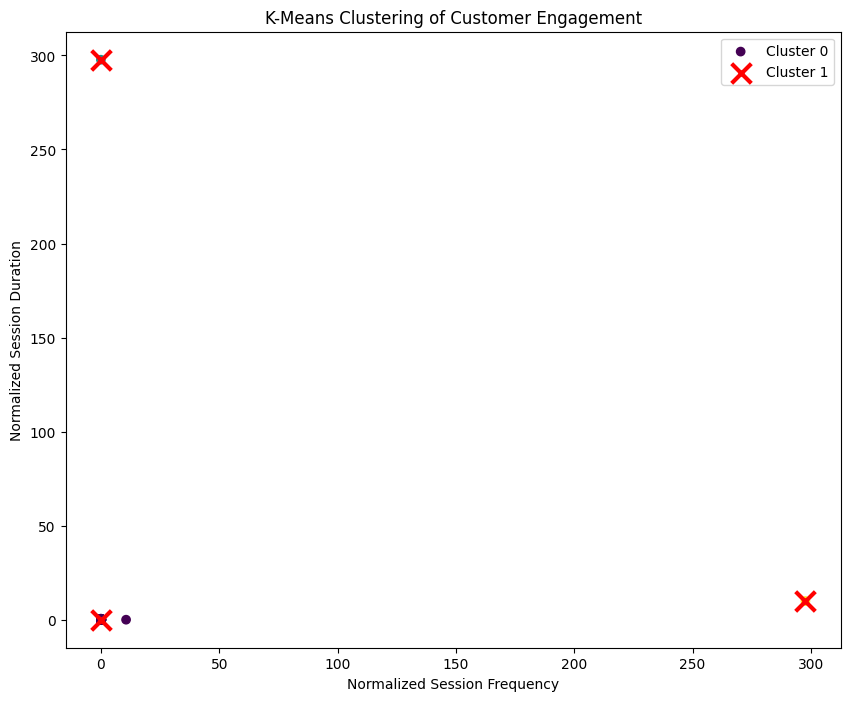

In [34]:


# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='red')
plt.title('K-Means Clustering of Customer Engagement')
plt.xlabel('Normalized Session Frequency')
plt.ylabel('Normalized Session Duration')
plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster Centers'], loc='best')
plt.show()


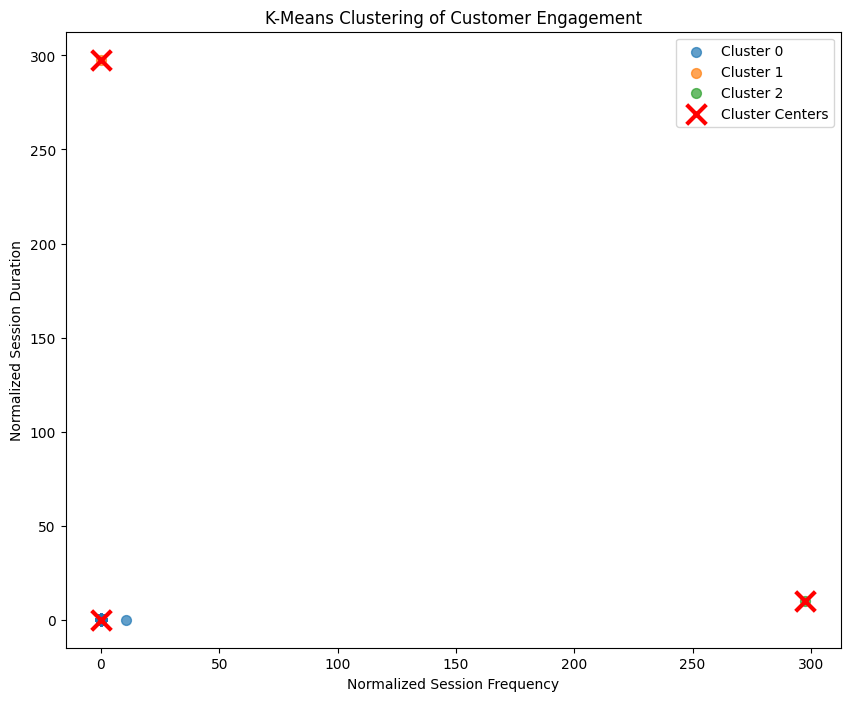

In [35]:
import matplotlib.pyplot as plt

# Plot the clusters
plt.figure(figsize=(10, 8))

# Plot the data points
for cluster in range(3):
    cluster_data = X[kmeans.labels_ == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=50, alpha=0.7, label=f'Cluster {cluster}')

# Plot the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='red', label='Cluster Centers')

plt.title('K-Means Clustering of Customer Engagement')
plt.xlabel('Normalized Session Frequency')
plt.ylabel('Normalized Session Duration')
plt.legend(loc='best')
plt.show()


In [ ]:
import pandas as pd

# Assuming the data is in a pandas DataFrame named 'df'
df_aggregated = df.groupby('MSISDN/Number').agg(
    Sessions_Frequency=('Bearer Id', 'count'),
    Session_Duration=('Dur. (ms)', 'sum'),
    Total_DL_Bytes=('Total DL (Bytes)', 'sum'),
    Total_UL_Bytes=('Total UL (Bytes)', 'sum')
).reset_index()

df_aggregated['Total_Traffic'] = df_aggregated['Total_DL_Bytes'] + df_aggregated['Total_UL_Bytes']

# Report the top 10 customers per engagement metric
print("Top 10 customers by sessions frequency:")
print(df_aggregated.sort_values('Sessions_Frequency', ascending=False).head(10))

print("\nTop 10 customers by session duration:")
print(df_aggregated.sort_values('Session_Duration', ascending=False).head(10))

print("\nTop 10 customers by total traffic:")
print(df_aggregated.sort_values('Total_Traffic', ascending=False).head(10))


# Calculate the engagement score for each user

In [7]:
# Calculate the average of the three metrics for each user
average_total_traffic_per_user = df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().mean(axis=1)
average_total_session_duration_per_user = df.groupby('MSISDN/Number')['Dur. (ms)'].sum().groupby('MSISDN/Number').mean()
average_session_frequency_per_user = df['MSISDN/Number'].value_counts().groupby('MSISDN/Number').mean()

# Calculate the average of the three metrics for each user
average_metrics_per_user = (average_total_traffic_per_user + average_total_session_duration_per_user + average_session_frequency_per_user) / 3

# Report the top 10 customers based on the average of the three metrics
top_10_average_metrics = average_metrics_per_user.nlargest(10)
print("Top 10 Customers by Average of the Three Metrics:")
print(top_10_average_metrics)





Top 10 Customers by Average of the Three Metrics:
MSISDN/Number
3.373167e+10    1.887238e+12
3.360304e+10    6.867157e+10
3.361489e+10    1.475671e+09
3.362578e+10    1.417983e+09
3.362632e+10    1.329863e+09
3.367588e+10    1.316296e+09
3.365973e+10    1.285475e+09
3.366646e+10    1.218949e+09
3.366471e+10    1.146257e+09
3.369879e+10    1.091030e+09
dtype: float64


In [19]:
print(df.dtypes)

Bearer Id                         float64
Start                              object
Start ms                          float64
End                                object
End ms                            float64
Dur. (ms)                         float64
IMSI                              float64
MSISDN/Number                     float64
IMEI                              float64
Last Location Name                 object
Avg RTT DL (ms)                   float64
Avg RTT UL (ms)                   float64
Avg Bearer TP DL (kbps)           float64
Avg Bearer TP UL (kbps)           float64
TCP DL Retrans. Vol (Bytes)       float64
TCP UL Retrans. Vol (Bytes)       float64
DL TP < 50 Kbps (%)               float64
50 Kbps < DL TP < 250 Kbps (%)    float64
250 Kbps < DL TP < 1 Mbps (%)     float64
DL TP > 1 Mbps (%)                float64
UL TP < 10 Kbps (%)               float64
10 Kbps < UL TP < 50 Kbps (%)     float64
50 Kbps < UL TP < 300 Kbps (%)    float64
UL TP > 300 Kbps (%)              